In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# CRISP-DM process
## Business Understanding

When living on crowded cities or big urban centers, traffic won't pass unnoticed. All day long cars, trucks, buses and motorcycles interact, competing for street space, and in motion. Is there any way a to proof assumptions about traffic using data science? For sure is! 

In this notebook will be ansewered the following questions:
* **Which lane on a road have the highest speed?**
* **How does the features correlate?**
* **How good can a new car be classified?**



## Data Understanding

On the code below will be explored data from traffic radars of São Paulo, on March, 2018.

The features here have the especifications about lenght, type and register of vehycles and the place, lane where it was capture. All is organized by date.


### The next steps of CRISP-DM process are done for each analysis 
* Prepare Data
* Data Modeling
* Evaluate the Results

# Which lane on a road have the highest speed?

## Importing first databases

Radars.csv contains all cars, trucks, motorcycles and buses that comes thru São Paulo's radar system 


In [27]:
# to download the data, access https://drive.google.com/file/d/1VG-t8t1mq_HZV-Ue6zkth_3Ne4IfCOrq/view?usp=sharing 

df_base = pd.read_csv(r"Radar_Data_2.03.2018.csv", index_col= "Data")


In [28]:
df_base.head()

,Unnamed: 0,Lote,Local,Numero Agrupado,Faixa,Entrefaixa,Registro,Tipo de Registro,Veiculo,Final de Placa,Especie,Classe,Comprimento,Velocidade,Ocupacao
Data,,,,,,,,,,,,,,,
2018-03-01 23:56:00,0,L3,5415,10588,2,0,32526,0,,,1.0,0.0,45.0,103.0,808.0
2018-03-01 23:56:00,1,L3,5415,10588,2,0,32527,0,,,0.0,0.0,13.0,69.0,445.0
2018-03-01 23:56:00,2,L3,5415,10588,3,0,32528,0,,,1.0,0.0,34.0,106.0,736.0
2018-03-01 23:57:00,3,L3,5415,10588,2,0,32529,0,803997,8,0.0,0.0,13.0,42.0,939.0
2018-03-01 23:57:00,4,L3,5415,10588,1,0,32530,0,989773,3,1.0,0.0,40.0,53.0,1446.0


### Reading the columns

* **Radar** is the number of identification of a street section
* **Lane** goes from 1 to 6 in most radars, low lane number are closer to the center of the freeway, high lane numbers are "local" lanes, to the right
* **Register** represents each vehicle
* **Types** are: motorcycle = 0, car = 1, bus = 2 ou truck = 3
* **Classes** are: *light* (motorcycle and car) = 0 ou *heavy* (bus and truck)  = 1
* **Speeds** are in kilometer per hour
* **Radar_Lane** comes to identify each lane on a single radar (will be usefull to merge dataframes)


### Prepare Data

In [29]:
# Preprocessing

df = df_base[["Numero Agrupado", "Faixa", "Registro", "Especie", "Classe", "Velocidade"]]
# turns speed from dm/s to km/h
df.loc[:,"Velocidade"] = df.loc[:,"Velocidade"] * 0.36

df.index.names = ["Date"]

df["Radar_Lane"] = df["Numero Agrupado"].astype(str) + df["Faixa"].astype(str)

# renaming columns to english
df.columns = ["Radar", "Lane", "Register", "Type", "Class", "Speed [km/h]", "Radar_Lane"]

df.head()

,Radar,Lane,Register,Type,Class,Speed [km/h],Radar_Lane
Date,,,,,,,
2018-03-01 23:56:00,10588,2,32526,1.0,0.0,37.08,105882
2018-03-01 23:56:00,10588,2,32527,0.0,0.0,24.84,105882
2018-03-01 23:56:00,10588,3,32528,1.0,0.0,38.16,105883
2018-03-01 23:57:00,10588,2,32529,0.0,0.0,15.12,105882
2018-03-01 23:57:00,10588,1,32530,1.0,0.0,19.08,105881


### Lane types database

Helps to tell the **use of each lane** . 

"Tipo" contains the information of lanes where all types of vehicycles can use ( *mix_use* ) and other that are for buses only ( *exclusive_bus* )

In [30]:
lane_types = pd.read_excel(r"Lanes_type.xlsx", usecols = ["Num_agrupado"," faixa", "Num_fx", "tipo"],engine='openpyxl')


In [31]:
lane_types.head()

,Num_agrupado,faixa,Num_fx,tipo
0,10426,1,104261,mista
1,10426,2,104262,mista
2,10426,3,104263,mista
3,10426,4,104264,onibus
4,10433,1,104331,mista


### Merge dataframes

To identify the type of the lane, if it is exclusive for buses, or multipurpose

In [32]:
df_merged = lane_types[["Num_fx", "tipo"]].merge(df, left_on = "Num_fx", right_on = "Radar_Lane", how="right")

df_merged["Lane_use"] = df_merged["tipo"].map({"mista":"mix_use", "onibus": "exclusive_bus"})

df_merged = df_merged[["Radar", "Lane", "Register", "Type", "Class", "Speed [km/h]", "Lane_use"]]

df_merged.head()

,Radar,Lane,Register,Type,Class,Speed [km/h],Lane_use
0,10588,2,32526,1.0,0.0,37.08,mix_use
1,10588,2,32527,0.0,0.0,24.84,mix_use
2,10588,2,32529,0.0,0.0,15.12,mix_use
3,10588,2,32533,1.0,0.0,28.08,mix_use
4,10588,2,32539,1.0,0.0,45.00,mix_use


### Looking for NaNs

As shown below, NaNs are less than 1% (actually, less than 0,2%)

With this information, there will be low loss in dropping NaNs



In [33]:
print(df_merged.isna().mean() * 100)

df_merged.dropna(inplace=True)

Radar           0.000000
Lane            0.000000
Register        0.000000
Type            0.185455
Class           0.185455
Speed [km/h]    0.185455
Lane_use        0.000000
dtype: float64


### Selection of Lanes

Using only the data from mix_use lanes, select for each lane to create comparison

The max number of lanes is 6, but only few roads have all 6, so it can be excluded from the analysis


In [34]:
lanes = df_merged.loc[df_merged["Lane_use"] == "mix_use"]

lane_1 = lanes.loc[lanes["Lane"] == 1]

lane_2 = lanes.loc[lanes["Lane"] == 2]

lane_3 = lanes.loc[lanes["Lane"] == 3]

lane_4 = lanes.loc[lanes["Lane"] == 4]

lane_5 = lanes.loc[lanes["Lane"] == 5]

lane_6 = lanes.loc[lanes["Lane"] == 6]

print(lane_1.shape, lane_2.shape, lane_3.shape, lane_4.shape, lane_5.shape, lane_6.shape)

(364148, 7) (586260, 7) (436164, 7) (167320, 7) (22417, 7) (6075, 7)


### Plotting the means
### Data Modeling

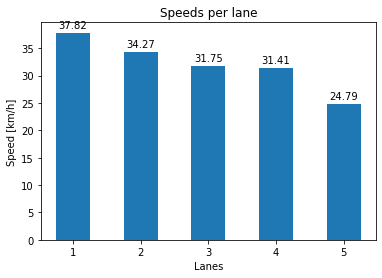

In [35]:
means = [ ]

for lane in [lane_1,lane_2,lane_3,lane_4,lane_5]:
    means.append(lane["Speed [km/h]"].mean())

means = [ round(elem, 2) for elem in means ]


fig, ax = plt.subplots()

rects = ax.bar([1,2,3,4,5],means, width= 0.5)

ax.set_ylabel("Speed [km/h]")
ax.set_xlabel("Lanes")
ax.set_title('Speeds per lane')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)


plt.show()

## Evaluating the Results

Center lanes move faster than "local" lanes

# How does the features correlate?


The new column is **Length** that represents the size of a vehicycle. Must be turn into meters

### Prepare Data

In [36]:
df_corr = df_base[["Numero Agrupado", "Faixa", "Registro", "Especie", "Classe", "Velocidade", "Comprimento"]]

df_corr.loc[:,"Comprimento"] = df_corr.loc[:,"Comprimento"] /10

df_corr.loc[:,"Velocidade"] = df_corr.loc[:,"Velocidade"] * 0.36

df_corr.columns = ["Radar", "Lane", "Register", "Type", "Class", "Speed [km/h]", "Length"]



### Data Modeling

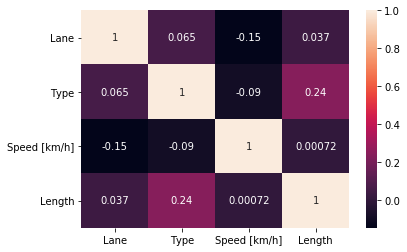

In [37]:
corrMatrix = df_corr[["Lane", "Type", "Speed [km/h]","Length"]].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

## Evaluating the Results

Is easy to see that *speed/lane* and *length/type* have the biggest correlations

High speeds correlates to low lane numbers, that means that center lanes move faster, as seen in other analysis (remembering the lane number grow from left to right)

Big lengths correlates with greater types that are heavier vehicycles like buses and trucks

# How good can a new car be classified?
### Prepare Data

In [38]:
df_regression = df_base[["Numero Agrupado", "Faixa", "Registro", "Especie", "Classe", "Velocidade", "Comprimento"]]

df_regression.loc[:,"Comprimento"] = df_regression.loc[:,"Comprimento"] /10

df_regression.loc[:,"Velocidade"] = df_regression.loc[:,"Velocidade"] * 0.36


In [39]:
df_regression.columns = ["Radar", "Lane", "Register", "Type", "Class", "Speed [km/h]", "Length"]


Validation = df_regression.loc[df_regression["Speed [km/h]"].isna()]
X = df_regression[["Lane", "Type", "Class", "Length"]].dropna()
X = pd.concat([pd.get_dummies(X[["Lane", "Type", "Class"]].astype("object")),X["Length"]], axis=1)

y = df_regression["Speed [km/h]"].dropna()


X.head()

,Lane_1,Lane_2,Lane_3,Lane_4,Lane_5,Lane_6,Type_0.0,Type_1.0,Type_2.0,Type_3.0,Class_0.0,Class_1.0,Length
Date,,,,,,,,,,,,,
2018-03-01 23:56:00,0,1,0,0,0,0,0,1,0,0,1,0,4.5
2018-03-01 23:56:00,0,1,0,0,0,0,1,0,0,0,1,0,1.3
2018-03-01 23:56:00,0,0,1,0,0,0,0,1,0,0,1,0,3.4
2018-03-01 23:57:00,0,1,0,0,0,0,1,0,0,0,1,0,1.3
2018-03-01 23:57:00,1,0,0,0,0,0,0,1,0,0,1,0,4.0


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data Modeling



In [41]:
regr = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
regr.fit(X_train, y_train)

print("R2 score with n_estimators={} and max_depth={} is {} ".format(50,10,regr.score(X_test,y_test)))


R2 score with n_estimators=50 and  max_depth=10 is 0.13035592245707572 


## Evaluating the Results

The Random Forest algorithm got an R2 score 13% when using 50 binary trees and max depth of 5 nodes. This is a good score considering that the model uses real world data.

At this point, the computational cost has a big role. With more estimators, depth, and tunning other hyperparameters is possible to have higher score, althoug it takes more time and computational power to run the model, and this is why it is a turning point.
